# Generate a color histogram lookup for weighting classifier

In [340]:
%matplotlib inline
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb, rgb2gray, xyz2lab
import numpy as np
from tqdm import tqdm_notebook as tqdm
from dataset import ColorizeHD5Dataset
from scipy.ndimage.filters import gaussian_filter
import torch.nn as nn
import torch.nn.functional as F
import torch
from sklearn.neighbors import NearestNeighbors

In [192]:
lab_bins = np.load('lab_idx.npy')
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))


### Reverse Engineer nn.CrossEntropyLoss to make sure i understand

In [11]:
tloss = nn.CrossEntropyLoss()

In [231]:
yhat = torch.FloatTensor([[0, 0, 1]])
yreal = torch.LongTensor([2])
ysoft = torch.FloatTensor([[0, 0, 1], [0, 0, 1]])

In [146]:
tloss(yhat, yreal)

tensor(0.5514)

In [151]:
yc = np.array([0,0,1])
ycn = np.exp(yc)/ sum(np.exp(yc))
yt = [0, 0, 1]

In [150]:
ycn

array([0.21194156, 0.21194156, 0.57611688])

In [154]:
-yc*np.log(ycn)

array([-0.        , -0.        ,  0.55144471])

### Lets work on colors

In [173]:
color_bins = np.double(lab_bins) * 10  - 128 +5

In [181]:
color_bins[1,:]

array([-83.,  57.])

In [214]:
num_nbrs = 7
nbrs = NearestNeighbors(n_neighbors=num_nbrs, algorithm='ball_tree').fit(color_bins)
distances, indices = nbrs.kneighbors(color_bins)

In [227]:
indices[0,:]

array([ 0,  7,  1,  8,  6, 16,  2])

In [216]:
weights = np.zeros((262,262))
for c in range(262):
    for n in range(num_nbrs):
        weights[c, indices[c,n]] = gaussian(0, distances[c, n], 8)

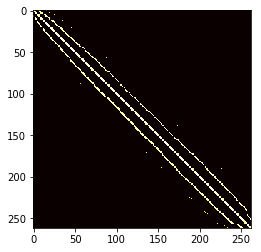

In [217]:
plt.imshow(np.log(weights + 1e-7), cmap='hot', interpolation='nearest')


Normalize weights down so each row sums to 1

In [221]:
final_weights = weights/weights.sum(axis=0)

In [229]:
final_weights[0,144]

0.0

In [230]:
np.save('soft_encoding.npy', final_weights)

In [1169]:
final_weights.shape

(262, 262)

In [1184]:
targets = np.random.randint(0, 262, size=(10, 1, 7, 8))
final_weights[targets].shape

(10, 1, 7, 8, 262)

for each Y target, final_weights[y] will give the **soft** encoded version of Y to use in the colorloss function

## Now lets work on that loss function

In [1179]:
class ColorLoss(nn.Module):
    
    def  __init__(self, weights=None):
        super(ColorLoss, self).__init__()
        self.weights = weights #/ weights.mean()
    
    def forward(self, label, target):
        log_sm_lbls = F.log_softmax(label, dim=1) # log softmax has nicer numerical properties
        bs, c, h, w = label.shape
        expanded_weights = self.weights[:,None,None].expand([262, h, w])
        divisor = torch.sum(expanded_weights * target)
        return -torch.sum( expanded_weights * target * log_sm_lbls) / divisor

pytorch encodings things as (bs, nchannel, h, w) , lets see if broadcasting works that way..

In [1171]:
w1 = torch.FloatTensor(np.random.randn(262))

In [1172]:

ptloss = nn.CrossEntropyLoss(w1, size_average=True)

Construct test cases

In [1173]:
labels = np.random.randn(10, 262, 7, 8)
targets = np.random.randint(0, 262, size=(10, 7, 8))
w1[targets.reshape(1,-1)].sum()

tensor(77.7250)

In [1174]:
ptloss(torch.FloatTensor(labels), torch.LongTensor(targets)).item()

5.821800708770752

In [1175]:
# gotta one hote encode this to pass to our function
targets_closs = np.zeros((10, 262, 7, 8))
for b in range(10):
    for h in range(7):
        for w in range(8):
            targets_closs[b, targets[b, h, w], h, w] = 1

In [1180]:
closs = ColorLoss(w1)

In [1181]:
closs(torch.FloatTensor(labels), torch.FloatTensor(targets_closs)).item()

5.821800231933594

### Exploration oft the torch cross entropy function

In [775]:
labels = torch.FloatTensor([[0.9, 0.4]])
targets = torch.LongTensor([1])
loss = nn.CrossEntropyLoss()
loss(labels, targets)

tensor(0.9741)

In [776]:
values = F.softmax(labels, dim=1).numpy().squeeze()
-np.sum(np.log(values) * np.array([0,1]), axis=0)

0.9740769863128662

In [796]:
w = torch.FloatTensor([0.9, 4.8])
w = w/w.sum()

In [797]:
-np.sum(np.log(values) * np.array([0,1] * w.numpy()), axis=0)

0.8202753630065729

In [798]:
loss = nn.CrossEntropyLoss(w, size_average=True)
loss(labels, targets).item()

0.9740769863128662